Tzvi Aviv
November 9th, 2021
Explore the creation of the dataset for hospital mortality prediction from mimic3


In [31]:
!pwd

/ssd003/home/taviv/mimic3-benchmarks


In [18]:
import pandas as pd

In [1]:
from __future__ import absolute_import
from __future__ import print_function

import numpy as np
import argparse
import os
import imp
import re

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

In [3]:
from mimic3models import common_utils
from mimic3models.in_hospital_mortality import utils
from mimic3benchmark.readers import InHospitalMortalityReader

from mimic3models.preprocessing import Discretizer, Normalizer

def read_and_extract_features(reader, period, features):
    ret = common_utils.read_chunk(reader, reader.get_number_of_examples())
    # ret = common_utils.read_chunk(reader, 100)
    X = common_utils.extract_features_from_rawdata(ret['X'], ret['header'], period, features)
    return (X, ret['y'], ret['name'])





parser = argparse.ArgumentParser()

parser.add_argument('--data', type=str, help='Path to the data of in-hospital mortality task',
                    default='/ssd003/home/taviv/mimic3-benchmarks/data/in-hospital-mortality/')
parser.add_argument('--output_dir', type=str, help='Directory relative which all output files are stored',
                    default='/ssd003/home/taviv/mimic3-benchmarks/data_ta')
args = parser.parse_args()

In [8]:
! ls /ssd003/home/taviv/mimic3-benchmarks/data/in-hospital-mortality/

test  test_listfile.csv  train	train_listfile.csv  val_listfile.csv


In [9]:
# Build readers, discretizers, normalizers
train_reader = InHospitalMortalityReader(dataset_dir='/ssd003/home/taviv/mimic3-benchmarks/data/in-hospital-mortality/train',
                                         listfile='/ssd003/home/taviv/mimic3-benchmarks/data/in-hospital-mortality/train_listfile.csv',
                                         period_length=48.0)


In [27]:
# Build readers, discretizers, normalizers
test_reader = InHospitalMortalityReader(dataset_dir='/ssd003/home/taviv/mimic3-benchmarks/data/in-hospital-mortality/test',
                                         listfile='/ssd003/home/taviv/mimic3-benchmarks/data/in-hospital-mortality/test_listfile.csv',
                                         period_length=48.0)

In [10]:
print('Reading data and extracting features ...')
(train_X, train_y, train_names) = read_and_extract_features(train_reader, "all", "all")

Reading data and extracting features ...


In [28]:
print('Reading data and extracting features ...')
(test_X, test_y, test_names) = read_and_extract_features(test_reader, "all", "all")

Reading data and extracting features ...


In [30]:
test_X.shape

(3236, 714)

In [12]:
train_X.shape

(14681, 714)

In [29]:
train_names[0]

'3977_episode4_timeseries.csv'

In [ ]:
#we want to get the subject id from train_names and add to the arrays or pd dfs

In [34]:
train_df = pd.DataFrame(train_X)
train_df["label"]=train_y

In [35]:
train_df["file"]=train_names

In [37]:
train_df[['SUBJ_ID','episode', 'ts']] = train_df['file'].str.split('_',expand=True)

In [38]:
train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,709,710,711,712,713,label,file,SUBJ_ID,episode,ts
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0,3977_episode4_timeseries.csv,3977,episode4,timeseries.csv
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.32,7.280000,0.032404,-0.440867,8.0,0,97271_episode1_timeseries.csv,97271,episode1,timeseries.csv
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.40,7.320000,0.043205,0.595170,12.0,0,29742_episode1_timeseries.csv,29742,episode1,timeseries.csv
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.00,5.000000,0.000000,0.000000,1.0,0,3362_episode1_timeseries.csv,3362,episode1,timeseries.csv
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.38,7.376667,0.004714,-0.707107,6.0,0,2187_episode2_timeseries.csv,2187,episode2,timeseries.csv


"file", and "ts" columns can be removed

In [40]:
train_df.SUBJ_ID.nunique()

12565

<AxesSubplot:>

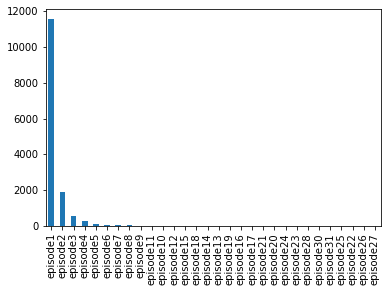

In [42]:
train_df.episode.value_counts().plot(kind='bar')

In [ ]:
#is mortality related to the episode number?

In [44]:
train_grp = train_df[['label','episode']].groupby('episode')

In [52]:
mr = pd.merge(train_grp.count(),train_grp.sum(), how = 'left', right_index=True, left_index=True)

In [54]:
mr.columns=['n', 'died']

In [55]:
mr['m_rate'] = mr.died/mr.n

In [59]:
mr.sort_values('m_rate', ascending=False, inplace=True)

<AxesSubplot:xlabel='episode'>

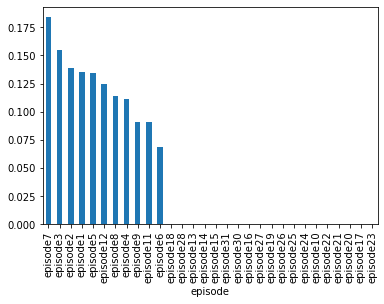

In [60]:
mr.m_rate.plot(kind='bar')

In [ ]:
#high mortality rate in episode 7 (?)

## now lets see mortality rates in the test data

In [61]:
test_df = pd.DataFrame(test_X)
test_df["label"]=test_y
test_df["file"]=test_names
test_df[['SUBJ_ID','episode', 'ts']] = test_df['file'].str.split('_',expand=True)

In [65]:
test_grp = test_df[['label','episode']].groupby('episode')
mr_test = pd.merge(test_grp.count(),test_grp.sum(), how = 'left', right_index=True, left_index=True)

In [66]:
mr_test.columns=['n', 'died']
mr_test['m_rate'] = mr_test.died/mr_test.n
mr_test.sort_values('m_rate', ascending=False, inplace=True)

<AxesSubplot:xlabel='episode'>

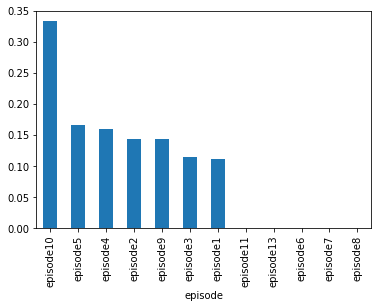

In [67]:
mr_test.m_rate.plot(kind='bar')

In [ ]:
#in the test set we get very high mortality rates in the 10th episode 

In [68]:
test_df.SUBJ_ID.nunique()

2763

In [ ]:
#another way to do it is from the listfile.csv

In [20]:
files = pd.read_csv("data/in-hospital-mortality/train_listfile.csv")

In [21]:
files.head()

,stay,y_true
0,3977_episode4_timeseries.csv,0
1,97271_episode1_timeseries.csv,0
2,29742_episode1_timeseries.csv,0
3,3362_episode1_timeseries.csv,0
4,2187_episode2_timeseries.csv,0


In [23]:
files[['SUBJ_ID','episode', 'ts']] = files['stay'].str.split('_',expand=True)

In [24]:
files.head()

,stay,y_true,SUBJ_ID,episode,ts
0,3977_episode4_timeseries.csv,0,3977,episode4,timeseries.csv
1,97271_episode1_timeseries.csv,0,97271,episode1,timeseries.csv
2,29742_episode1_timeseries.csv,0,29742,episode1,timeseries.csv
3,3362_episode1_timeseries.csv,0,3362,episode1,timeseries.csv
4,2187_episode2_timeseries.csv,0,2187,episode2,timeseries.csv


In [25]:
files.SUBJ_ID.nunique()

12565

In [26]:
files.shape

(14681, 5)